# ML Group project 1, Multiple Sclerosis (MS-disease)

## ML6, Integrify

### Hannu Kiiskinen & MdZubairul Haque , 2.1.2024

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

## Descriptive statistics

### Dataset

Prospective cohort study was conducted in Mexican mestizo patients newly diagnosed with CIS who presented at the National Institute of Neurology and Neurosurgery (NINN) in Mexico City, Mexico, between 2006 and 2010.

License: Other (CC BY 4.0)

In [34]:
# Load data
MS_data = pd.read_csv("ML_GroupProject1/conversion_predictors_of_clinically_isolated_syndrome_to_multiple_sclerosis.csv")
MS_data.head()

,Unnamed: 0,Gender,Age,Schooling,Breastfeeding,Varicella,Initial_Symptom,Mono_or_Polysymptomatic,Oligoclonal_Bands,LLSSEP,ULSSEP,VEP,BAEP,Periventricular_MRI,Cortical_MRI,Infratentorial_MRI,Spinal_Cord_MRI,Initial_EDSS,Final_EDSS,group
0,0,1,34,20.0,1,1,2.0,1,0,1,1,0,0,0,1,0,1,1.0,1.0,1
1,1,1,61,25.0,3,2,10.0,2,1,1,0,1,0,0,0,0,1,2.0,2.0,1
2,2,1,22,20.0,3,1,3.0,1,1,0,0,0,0,0,1,0,0,1.0,1.0,1
3,3,2,41,15.0,1,1,7.0,2,1,0,1,1,0,1,1,0,0,1.0,1.0,1
4,4,2,34,20.0,2,1,6.0,2,0,1,0,0,0,1,0,0,0,1.0,1.0,1


In [35]:
# Drop ID
MS_data = MS_data.drop('Unnamed: 0', axis=1)
# Set group value 2 to 0
MS_data.group = MS_data.group.map({2:0, 1:1})

## Data review

8621 entries, 7 columns.

One field as datetime, six fields as float.

In [36]:
MS_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   273 non-null    int64  
 1   Age                      273 non-null    int64  
 2   Schooling                272 non-null    float64
 3   Breastfeeding            273 non-null    int64  
 4   Varicella                273 non-null    int64  
 5   Initial_Symptom          272 non-null    float64
 6   Mono_or_Polysymptomatic  273 non-null    int64  
 7   Oligoclonal_Bands        273 non-null    int64  
 8   LLSSEP                   273 non-null    int64  
 9   ULSSEP                   273 non-null    int64  
 10  VEP                      273 non-null    int64  
 11  BAEP                     273 non-null    int64  
 12  Periventricular_MRI      273 non-null    int64  
 13  Cortical_MRI             273 non-null    int64  
 14  Infratentorial_MRI       2

### Distribution of data

0    148
1    125
Name: group, dtype: int64


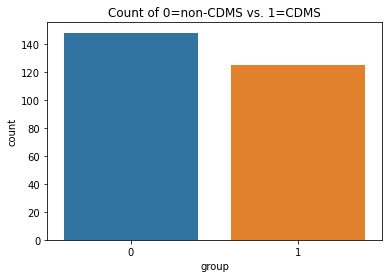

In [37]:
# Plot the distribution of CDMS/non-CDMS
print(MS_data.group.value_counts())
sns.countplot(x=MS_data['group']).set_title('Count of 0=non-CDMS vs. 1=CDMS')
plt.show()

### Check duplicates and outliers

In [38]:
#find duplicate rows across all columns
df0 = MS_data.drop('group', axis=1)
duplicateRows = df0[df0.duplicated()]
len(duplicateRows)

0

<AxesSubplot:>

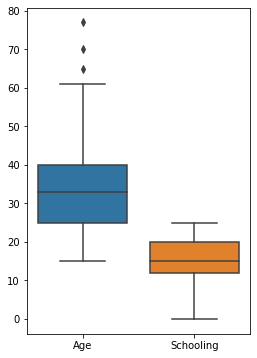

In [39]:
# BoxPlot to show ourliers
df1 = MS_data.filter(items=['Age', 'Schooling'])
plt.figure(figsize=(4, 6))
sns.boxplot(data=df1)

### Dataset column descriptions

- Age: Age of the patient (in years)
- Schooling: time the patient spent in school (in years)
- Gender: 1=male, 2=female
- Breastfeeding: 1=yes, 2=no, 3=unknown
- Varicella: 1=positive, 2=negative, 3=unknown
- Initial_Symptoms: 1=visual, 2=sensory, 3=motor, 4=other, 5= visual and sensory, 6=visual and motor, 7=visual and others, 8=sensory and motor, 9=sensory and other, 10=motor and other, 11=Visual, sensory and motor, 12=visual, sensory and other, 13=Visual, motor and other, 14=Sensory, motor and other, 15=visual,sensory,motor and other
- Mono _or_Polysymptomatic: 1=monosymptomatic, 2=polysymptomatic, 3=unknown
- Oligoclonal_Bands: 0=negative, 1=positive, 2=unknown
- LLSSEP: 0=negative, 1=positive
- ULSSEP:0=negative, 1=positive
- VEP:0=negative, 1=positive
- BAEP: 0=negative, 1=positive
- Periventricular_MRI:0=negative, 1=positive
- Cortical_MRI: 0=negative, 1=positive
- Infratentorial_MRI:0=negative, 1=positive
- Spinal_Cord_MRI: 0=negative, 1=positive
- initial_EDSS:?
- final_EDSS:?
- Group: 1=CDMS, 2=non-CDMS

intial_EDSS and final_EDSS have lot of missing values, The Expanded Disability Status Scale (EDSS) is a method of quantifying disability in multiple sclerosis and monitoring changes in the level of disability over time. It is widely used in clinical trials and in the assessment of people with MS.

In [42]:
# Handling the one row having nan-value in Schooling
# MS_data[MS_data.isna().any(axis=1)]
# MS_data.Schooling.value_counts()
MS_data.at[204,'Schooling'] = 20.0  # Use the most common value (just one nan-value)

In [43]:
# Handling the missing values
MS_data.at[238,'Initial_Symptom'] = 8.0  # Use the most common value (just one value missing)
MS_data = MS_data.drop('Initial_EDSS', axis=1)
MS_data = MS_data.drop('Final_EDSS', axis=1)
MS_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   273 non-null    int64  
 1   Age                      273 non-null    int64  
 2   Schooling                273 non-null    float64
 3   Breastfeeding            273 non-null    int64  
 4   Varicella                273 non-null    int64  
 5   Initial_Symptom          273 non-null    float64
 6   Mono_or_Polysymptomatic  273 non-null    int64  
 7   Oligoclonal_Bands        273 non-null    int64  
 8   LLSSEP                   273 non-null    int64  
 9   ULSSEP                   273 non-null    int64  
 10  VEP                      273 non-null    int64  
 11  BAEP                     273 non-null    int64  
 12  Periventricular_MRI      273 non-null    int64  
 13  Cortical_MRI             273 non-null    int64  
 14  Infratentorial_MRI       2

<AxesSubplot:>

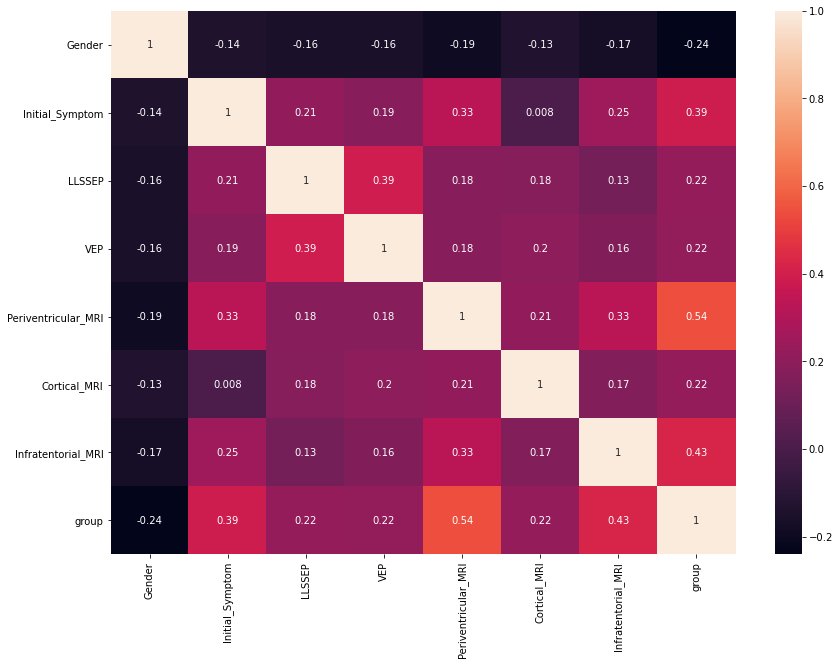

In [44]:
#__________Best Features________________
CM = MS_data.corr()
threshold = 0.2

features_names = list(CM.columns[np.abs(CM['group'])>=threshold])
features = CM.loc[:, features_names].loc[features_names, :]

plt.figure(figsize=(14, 10))
sns.heatmap(features, annot=True)

### Split the data

In [46]:
# Initial_EDSS and Final_EDSS cut away

# _________Split Dataset to Train and Test_____________
train, test = train_test_split(MS_data, test_size=0.2, random_state=31)
X_train, y_train = train.iloc[:, 0:15].to_numpy(), train.iloc[:, 16].to_numpy()
X_test, y_test = test.iloc[:, 0:15].to_numpy(), test.iloc[:, 16].to_numpy()

# ________Scaling the Features________________

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### First classifier

In [47]:
Classifier = LogisticRegression(random_state = 32)
Classifier.fit(X_train, y_train)

lr_preds_train = Classifier.predict(X_train)
acc = round(accuracy_score(y_train, lr_preds_train), 3)*100
print(f'The training accuracy of the model is {acc}')

lr_pred_test = Classifier.predict(X_test)
acc = round(accuracy_score(y_test, lr_pred_test), 3)*100
print(f'The accuracy of the test is {acc}')

The training accuracy of the model is 84.89999999999999
The accuracy of the test is 78.2


### Second classifier

In [48]:
# Make an instance of the Model
clf = DecisionTreeClassifier(max_depth = 8, criterion='entropy')

# Train the model on the data
clf.fit(X_train, y_train)

clf_preds_train = clf.predict(X_train)
acc = round(accuracy_score(y_train, clf_preds_train), 3)*100
print(f'The training accuracy of the model is {acc}')

clf_pred_test = clf.predict(X_test)
acc = round(accuracy_score(y_test, clf_pred_test), 3)*100
print(f'The accuracy of the test is {acc}')

The training accuracy of the model is 97.7
The accuracy of the test is 81.8


### AdaBoost

In [49]:
clf = AdaBoostClassifier(n_estimators=40, random_state=42)
clf.fit(X_train, y_train)

clf_preds_train = clf.predict(X_train)
acc = round(accuracy_score(y_train, clf_preds_train), 3)*100
print(f'The training accuracy of the model is {acc}')

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)*100
confusion_mat = confusion_matrix(y_test,y_pred)

# Printing the results
print("Accuracy for AdaBoost is:", round(accuracy, 1))

The training accuracy of the model is 91.7
Accuracy for AdaBoost is: 80.0


### SVC, GridSearch

In [50]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],  # Only for polynomial kernel
    'gamma': [0.01, 0.1, 1, 'scale'],  # 'scale' uses 1 / (n_features * X.var()) as gamma
    'class_weight': [None, 'balanced', {0: 1, 1: 2}]  # None means equal class weights
}

GS = GridSearchCV(SVC(), param_grid=param_grid, cv=3,verbose=3)# 

GS.fit(X_train, y_train)

preds_train = GS.predict(X_train)
acc = round(accuracy_score(y_train, preds_train), 3)*100
print(f'The accuracy of the model is {acc}')

pred_test = GS.predict(X_test)
acc = round(accuracy_score(y_test, pred_test), 3)*100
print(f'The accuracy of the test is {acc}')

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV 1/3] END C=0.1, class_weight=None, degree=2, gamma=0.01, kernel=linear;, score=0.808 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, degree=2, gamma=0.01, kernel=linear;, score=0.808 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, degree=2, gamma=0.01, kernel=linear;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.1, class_weight=None, degree=2, gamma=0.01, kernel=poly;, score=0.548 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, degree=2, gamma=0.01, kernel=poly;, score=0.562 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, degree=2, gamma=0.01, kernel=poly;, score=0.556 total time=   0.0s
[CV 1/3] END C=0.1, class_weight=None, degree=2, gamma=0.01, kernel=rbf;, score=0.548 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=None, degree=2, gamma=0.01, kernel=rbf;, score=0.562 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=None, degree=2, gamma=0.01, kernel=rbf;, score=0.55

[CV 1/3] END C=0.1, class_weight=balanced, degree=2, gamma=0.01, kernel=rbf;, score=0.603 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, degree=2, gamma=0.01, kernel=rbf;, score=0.616 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, degree=2, gamma=0.01, kernel=rbf;, score=0.611 total time=   0.0s
[CV 1/3] END C=0.1, class_weight=balanced, degree=2, gamma=0.01, kernel=sigmoid;, score=0.562 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, degree=2, gamma=0.01, kernel=sigmoid;, score=0.562 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, degree=2, gamma=0.01, kernel=sigmoid;, score=0.444 total time=   0.0s
[CV 1/3] END C=0.1, class_weight=balanced, degree=2, gamma=0.1, kernel=linear;, score=0.808 total time=   0.0s
[CV 2/3] END C=0.1, class_weight=balanced, degree=2, gamma=0.1, kernel=linear;, score=0.808 total time=   0.0s
[CV 3/3] END C=0.1, class_weight=balanced, degree=2, gamma=0.1, kernel=linear;, score=0.792 total time=   0.0s
[

[CV 1/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=2, gamma=0.01, kernel=poly;, score=0.452 total time=   0.0s
[CV 2/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=2, gamma=0.01, kernel=poly;, score=0.438 total time=   0.0s
[CV 3/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=2, gamma=0.01, kernel=poly;, score=0.444 total time=   0.0s
[CV 1/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=2, gamma=0.01, kernel=rbf;, score=0.452 total time=   0.0s
[CV 2/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=2, gamma=0.01, kernel=rbf;, score=0.438 total time=   0.0s
[CV 3/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=2, gamma=0.01, kernel=rbf;, score=0.444 total time=   0.0s
[CV 1/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=2, gamma=0.01, kernel=sigmoid;, score=0.452 total time=   0.0s
[CV 2/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=2, gamma=0.01, kernel=sigmoid;, score=0.438 total time=   0.0s
[CV 3/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=2, gamma=0.01, kernel=sigmoid;,

[CV 3/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=linear;, score=0.764 total time=   0.0s
[CV 1/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=poly;, score=0.466 total time=   0.0s
[CV 2/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=poly;, score=0.452 total time=   0.0s
[CV 3/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=poly;, score=0.458 total time=   0.0s
[CV 1/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=rbf;, score=0.575 total time=   0.0s
[CV 2/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=rbf;, score=0.493 total time=   0.0s
[CV 3/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=rbf;, score=0.500 total time=   0.0s
[CV 1/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=sigmoid;, score=0.795 total time=   0.0s
[CV 2/3] END C=0.1, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=s

[CV 1/3] END C=1, class_weight=None, degree=3, gamma=1, kernel=sigmoid;, score=0.671 total time=   0.0s
[CV 2/3] END C=1, class_weight=None, degree=3, gamma=1, kernel=sigmoid;, score=0.726 total time=   0.0s
[CV 3/3] END C=1, class_weight=None, degree=3, gamma=1, kernel=sigmoid;, score=0.611 total time=   0.0s
[CV 1/3] END C=1, class_weight=None, degree=3, gamma=scale, kernel=linear;, score=0.781 total time=   0.0s
[CV 2/3] END C=1, class_weight=None, degree=3, gamma=scale, kernel=linear;, score=0.808 total time=   0.0s
[CV 3/3] END C=1, class_weight=None, degree=3, gamma=scale, kernel=linear;, score=0.764 total time=   0.0s
[CV 1/3] END C=1, class_weight=None, degree=3, gamma=scale, kernel=poly;, score=0.767 total time=   0.0s
[CV 2/3] END C=1, class_weight=None, degree=3, gamma=scale, kernel=poly;, score=0.781 total time=   0.0s
[CV 3/3] END C=1, class_weight=None, degree=3, gamma=scale, kernel=poly;, score=0.861 total time=   0.0s
[CV 1/3] END C=1, class_weight=None, degree=3, gamma

[CV 1/3] END C=1, class_weight=balanced, degree=3, gamma=scale, kernel=poly;, score=0.795 total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, degree=3, gamma=scale, kernel=poly;, score=0.781 total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, degree=3, gamma=scale, kernel=poly;, score=0.847 total time=   0.0s
[CV 1/3] END C=1, class_weight=balanced, degree=3, gamma=scale, kernel=rbf;, score=0.795 total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, degree=3, gamma=scale, kernel=rbf;, score=0.767 total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, degree=3, gamma=scale, kernel=rbf;, score=0.833 total time=   0.0s
[CV 1/3] END C=1, class_weight=balanced, degree=3, gamma=scale, kernel=sigmoid;, score=0.822 total time=   0.0s
[CV 2/3] END C=1, class_weight=balanced, degree=3, gamma=scale, kernel=sigmoid;, score=0.808 total time=   0.0s
[CV 3/3] END C=1, class_weight=balanced, degree=3, gamma=scale, kernel=sigmoid;, score=0.764 total time=   0.0s
[CV 1/3] END 

[CV 3/3] END C=1, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=rbf;, score=0.819 total time=   0.0s
[CV 1/3] END C=1, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=sigmoid;, score=0.781 total time=   0.0s
[CV 2/3] END C=1, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=sigmoid;, score=0.781 total time=   0.0s
[CV 3/3] END C=1, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=sigmoid;, score=0.708 total time=   0.0s
[CV 1/3] END C=1, class_weight={0: 1, 1: 2}, degree=4, gamma=0.01, kernel=linear;, score=0.767 total time=   0.0s
[CV 2/3] END C=1, class_weight={0: 1, 1: 2}, degree=4, gamma=0.01, kernel=linear;, score=0.767 total time=   0.0s
[CV 3/3] END C=1, class_weight={0: 1, 1: 2}, degree=4, gamma=0.01, kernel=linear;, score=0.792 total time=   0.0s
[CV 1/3] END C=1, class_weight={0: 1, 1: 2}, degree=4, gamma=0.01, kernel=poly;, score=0.452 total time=   0.0s
[CV 2/3] END C=1, class_weight={0: 1, 1: 2}, degree=4, gamma=0.01, kernel=poly;, score

[CV 2/3] END C=10, class_weight=None, degree=3, gamma=0.1, kernel=rbf;, score=0.740 total time=   0.0s
[CV 3/3] END C=10, class_weight=None, degree=3, gamma=0.1, kernel=rbf;, score=0.819 total time=   0.0s
[CV 1/3] END C=10, class_weight=None, degree=3, gamma=0.1, kernel=sigmoid;, score=0.767 total time=   0.0s
[CV 2/3] END C=10, class_weight=None, degree=3, gamma=0.1, kernel=sigmoid;, score=0.753 total time=   0.0s
[CV 3/3] END C=10, class_weight=None, degree=3, gamma=0.1, kernel=sigmoid;, score=0.750 total time=   0.0s
[CV 1/3] END C=10, class_weight=None, degree=3, gamma=1, kernel=linear;, score=0.726 total time=   0.0s
[CV 2/3] END C=10, class_weight=None, degree=3, gamma=1, kernel=linear;, score=0.795 total time=   0.0s
[CV 3/3] END C=10, class_weight=None, degree=3, gamma=1, kernel=linear;, score=0.778 total time=   0.0s
[CV 1/3] END C=10, class_weight=None, degree=3, gamma=1, kernel=poly;, score=0.795 total time=   0.0s
[CV 2/3] END C=10, class_weight=None, degree=3, gamma=1, ke

[CV 1/3] END C=10, class_weight=balanced, degree=2, gamma=1, kernel=poly;, score=0.507 total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, degree=2, gamma=1, kernel=poly;, score=0.562 total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, degree=2, gamma=1, kernel=poly;, score=0.514 total time=   0.0s
[CV 1/3] END C=10, class_weight=balanced, degree=2, gamma=1, kernel=rbf;, score=0.562 total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, degree=2, gamma=1, kernel=rbf;, score=0.562 total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, degree=2, gamma=1, kernel=rbf;, score=0.556 total time=   0.0s
[CV 1/3] END C=10, class_weight=balanced, degree=2, gamma=1, kernel=sigmoid;, score=0.671 total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, degree=2, gamma=1, kernel=sigmoid;, score=0.712 total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, degree=2, gamma=1, kernel=sigmoid;, score=0.653 total time=   0.0s
[CV 1/3] END C=10, class_weight=balanced

[CV 3/3] END C=10, class_weight=balanced, degree=4, gamma=1, kernel=rbf;, score=0.556 total time=   0.0s
[CV 1/3] END C=10, class_weight=balanced, degree=4, gamma=1, kernel=sigmoid;, score=0.671 total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, degree=4, gamma=1, kernel=sigmoid;, score=0.712 total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, degree=4, gamma=1, kernel=sigmoid;, score=0.653 total time=   0.0s
[CV 1/3] END C=10, class_weight=balanced, degree=4, gamma=scale, kernel=linear;, score=0.726 total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, degree=4, gamma=scale, kernel=linear;, score=0.808 total time=   0.0s
[CV 3/3] END C=10, class_weight=balanced, degree=4, gamma=scale, kernel=linear;, score=0.792 total time=   0.0s
[CV 1/3] END C=10, class_weight=balanced, degree=4, gamma=scale, kernel=poly;, score=0.630 total time=   0.0s
[CV 2/3] END C=10, class_weight=balanced, degree=4, gamma=scale, kernel=poly;, score=0.616 total time=   0.0s
[CV 3/3] END

[CV 3/3] END C=10, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=linear;, score=0.792 total time=   0.0s
[CV 1/3] END C=10, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=poly;, score=0.808 total time=   0.0s
[CV 2/3] END C=10, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=poly;, score=0.753 total time=   0.0s
[CV 3/3] END C=10, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=poly;, score=0.889 total time=   0.0s
[CV 1/3] END C=10, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=rbf;, score=0.699 total time=   0.0s
[CV 2/3] END C=10, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=rbf;, score=0.740 total time=   0.0s
[CV 3/3] END C=10, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=rbf;, score=0.806 total time=   0.0s
[CV 1/3] END C=10, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=sigmoid;, score=0.753 total time=   0.0s
[CV 2/3] END C=10, class_weight={0: 1, 1: 2}, degree=3, gamma=scale, kernel=sigmoid;, 

[CV 3/3] END C=100, class_weight=None, degree=2, gamma=1, kernel=linear;, score=0.792 total time=   0.0s
[CV 1/3] END C=100, class_weight=None, degree=2, gamma=1, kernel=poly;, score=0.507 total time=   0.0s
[CV 2/3] END C=100, class_weight=None, degree=2, gamma=1, kernel=poly;, score=0.562 total time=   0.0s
[CV 3/3] END C=100, class_weight=None, degree=2, gamma=1, kernel=poly;, score=0.514 total time=   0.0s
[CV 1/3] END C=100, class_weight=None, degree=2, gamma=1, kernel=rbf;, score=0.562 total time=   0.0s
[CV 2/3] END C=100, class_weight=None, degree=2, gamma=1, kernel=rbf;, score=0.562 total time=   0.0s
[CV 3/3] END C=100, class_weight=None, degree=2, gamma=1, kernel=rbf;, score=0.556 total time=   0.0s
[CV 1/3] END C=100, class_weight=None, degree=2, gamma=1, kernel=sigmoid;, score=0.658 total time=   0.0s
[CV 2/3] END C=100, class_weight=None, degree=2, gamma=1, kernel=sigmoid;, score=0.699 total time=   0.0s
[CV 3/3] END C=100, class_weight=None, degree=2, gamma=1, kernel=sig

[CV 3/3] END C=100, class_weight=None, degree=4, gamma=0.1, kernel=linear;, score=0.792 total time=   0.0s
[CV 1/3] END C=100, class_weight=None, degree=4, gamma=0.1, kernel=poly;, score=0.616 total time=   0.0s
[CV 2/3] END C=100, class_weight=None, degree=4, gamma=0.1, kernel=poly;, score=0.603 total time=   0.0s
[CV 3/3] END C=100, class_weight=None, degree=4, gamma=0.1, kernel=poly;, score=0.569 total time=   0.0s
[CV 1/3] END C=100, class_weight=None, degree=4, gamma=0.1, kernel=rbf;, score=0.726 total time=   0.0s
[CV 2/3] END C=100, class_weight=None, degree=4, gamma=0.1, kernel=rbf;, score=0.740 total time=   0.0s
[CV 3/3] END C=100, class_weight=None, degree=4, gamma=0.1, kernel=rbf;, score=0.819 total time=   0.0s
[CV 1/3] END C=100, class_weight=None, degree=4, gamma=0.1, kernel=sigmoid;, score=0.740 total time=   0.0s
[CV 2/3] END C=100, class_weight=None, degree=4, gamma=0.1, kernel=sigmoid;, score=0.781 total time=   0.0s
[CV 3/3] END C=100, class_weight=None, degree=4, g

[CV 1/3] END C=100, class_weight=balanced, degree=2, gamma=scale, kernel=sigmoid;, score=0.795 total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, degree=2, gamma=scale, kernel=sigmoid;, score=0.753 total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, degree=2, gamma=scale, kernel=sigmoid;, score=0.722 total time=   0.0s
[CV 1/3] END C=100, class_weight=balanced, degree=3, gamma=0.01, kernel=linear;, score=0.726 total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, degree=3, gamma=0.01, kernel=linear;, score=0.808 total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, degree=3, gamma=0.01, kernel=linear;, score=0.792 total time=   0.0s
[CV 1/3] END C=100, class_weight=balanced, degree=3, gamma=0.01, kernel=poly;, score=0.753 total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, degree=3, gamma=0.01, kernel=poly;, score=0.795 total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, degree=3, gamma=0.01, kernel=poly;, score=0.819 total time=

[CV 3/3] END C=100, class_weight=balanced, degree=4, gamma=1, kernel=sigmoid;, score=0.625 total time=   0.0s
[CV 1/3] END C=100, class_weight=balanced, degree=4, gamma=scale, kernel=linear;, score=0.726 total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, degree=4, gamma=scale, kernel=linear;, score=0.808 total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, degree=4, gamma=scale, kernel=linear;, score=0.792 total time=   0.0s
[CV 1/3] END C=100, class_weight=balanced, degree=4, gamma=scale, kernel=poly;, score=0.616 total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, degree=4, gamma=scale, kernel=poly;, score=0.603 total time=   0.0s
[CV 3/3] END C=100, class_weight=balanced, degree=4, gamma=scale, kernel=poly;, score=0.569 total time=   0.0s
[CV 1/3] END C=100, class_weight=balanced, degree=4, gamma=scale, kernel=rbf;, score=0.699 total time=   0.0s
[CV 2/3] END C=100, class_weight=balanced, degree=4, gamma=scale, kernel=rbf;, score=0.740 total time=   0.0

[CV 1/3] END C=100, class_weight={0: 1, 1: 2}, degree=3, gamma=0.1, kernel=linear;, score=0.781 total time=   0.0s
[CV 2/3] END C=100, class_weight={0: 1, 1: 2}, degree=3, gamma=0.1, kernel=linear;, score=0.781 total time=   0.0s
[CV 3/3] END C=100, class_weight={0: 1, 1: 2}, degree=3, gamma=0.1, kernel=linear;, score=0.792 total time=   0.0s
[CV 1/3] END C=100, class_weight={0: 1, 1: 2}, degree=3, gamma=0.1, kernel=poly;, score=0.795 total time=   0.0s
[CV 2/3] END C=100, class_weight={0: 1, 1: 2}, degree=3, gamma=0.1, kernel=poly;, score=0.753 total time=   0.0s
[CV 3/3] END C=100, class_weight={0: 1, 1: 2}, degree=3, gamma=0.1, kernel=poly;, score=0.889 total time=   0.0s
[CV 1/3] END C=100, class_weight={0: 1, 1: 2}, degree=3, gamma=0.1, kernel=rbf;, score=0.726 total time=   0.0s
[CV 2/3] END C=100, class_weight={0: 1, 1: 2}, degree=3, gamma=0.1, kernel=rbf;, score=0.740 total time=   0.0s
[CV 3/3] END C=100, class_weight={0: 1, 1: 2}, degree=3, gamma=0.1, kernel=rbf;, score=0.819

[CV 3/3] END C=100, class_weight={0: 1, 1: 2}, degree=4, gamma=scale, kernel=linear;, score=0.792 total time=   0.0s
[CV 1/3] END C=100, class_weight={0: 1, 1: 2}, degree=4, gamma=scale, kernel=poly;, score=0.616 total time=   0.0s
[CV 2/3] END C=100, class_weight={0: 1, 1: 2}, degree=4, gamma=scale, kernel=poly;, score=0.603 total time=   0.0s
[CV 3/3] END C=100, class_weight={0: 1, 1: 2}, degree=4, gamma=scale, kernel=poly;, score=0.569 total time=   0.0s
[CV 1/3] END C=100, class_weight={0: 1, 1: 2}, degree=4, gamma=scale, kernel=rbf;, score=0.699 total time=   0.0s
[CV 2/3] END C=100, class_weight={0: 1, 1: 2}, degree=4, gamma=scale, kernel=rbf;, score=0.740 total time=   0.0s
[CV 3/3] END C=100, class_weight={0: 1, 1: 2}, degree=4, gamma=scale, kernel=rbf;, score=0.806 total time=   0.0s
[CV 1/3] END C=100, class_weight={0: 1, 1: 2}, degree=4, gamma=scale, kernel=sigmoid;, score=0.767 total time=   0.0s
[CV 2/3] END C=100, class_weight={0: 1, 1: 2}, degree=4, gamma=scale, kernel=s

In [51]:
GS.best_estimator_

SVC(C=10, class_weight='balanced', kernel='poly')

In [52]:
svc = SVC(C=10, class_weight='balanced', kernel='poly')
svc.fit(X_train, y_train)

preds_train = svc.predict(X_train)
acc = round(accuracy_score(y_train, preds_train), 3)*100
print(f'The training accuracy of the model is {acc}')

pred_test = svc.predict(X_test)
acc = round(accuracy_score(y_test, pred_test), 3)*100
print(f'The accuracy of the test is {acc}')

The training accuracy of the model is 100.0
The accuracy of the test is 72.7


### RandomForest classifier

In [53]:
clf = RandomForestClassifier(max_depth=9, random_state=42)
clf.fit(X_train, y_train)

preds_train = clf.predict(X_train)
acc = round(accuracy_score(y_train, preds_train), 3)*100
print(f'The training accuracy of the model is {acc}')

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)*100
confusion_mat = confusion_matrix(y_test,y_pred)

# Printing the results
print("Accuracy for RandomForrest is:", round(accuracy, 1))
print("Confusion Matrix")
print(confusion_mat)

The training accuracy of the model is 100.0
Accuracy for RandomForrest is: 89.1
Confusion Matrix
[[25  2]
 [ 4 24]]


In [57]:
y_test,y_pred

(array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0], dtype=int64),
 array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0], dtype=int64))

### Checking the wrong predictions

Periventricular_MRI        0.163021
Initial_Symptom            0.140621
Age                        0.116625
Infratentorial_MRI         0.094961
Schooling                  0.092847
Oligoclonal_Bands          0.068848
Varicella                  0.058545
Breastfeeding              0.051560
LLSSEP                     0.038787
Cortical_MRI               0.037602
Gender                     0.033279
Mono_or_Polysymptomatic    0.032427
VEP                        0.029576
ULSSEP                     0.028816
BAEP                       0.012485
dtype: float64

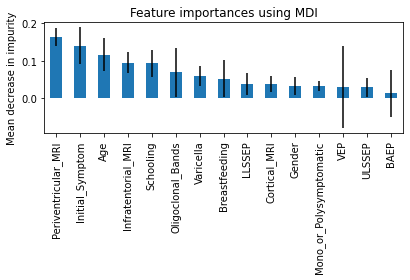

In [54]:
# Print important features
feature_names = [f"{i}" for i in test.columns.tolist()[0:15]]
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
clf_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots()
clf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
clf_importances.sort_values(ascending=False)

In [55]:
# Print wrongly predicted rows
wrong = np.where(y_test!=y_pred)
wrong = wrong[0].tolist()
test.iloc[wrong]

,Gender,Age,Schooling,Breastfeeding,Varicella,Initial_Symptom,Mono_or_Polysymptomatic,Oligoclonal_Bands,LLSSEP,ULSSEP,VEP,BAEP,Periventricular_MRI,Cortical_MRI,Infratentorial_MRI,Spinal_Cord_MRI,group
117,2,52,15.0,1,1,8.0,2,1,0,1,0,0,0,0,0,1,1
33,1,38,15.0,2,1,3.0,1,0,0,1,0,1,0,0,0,1,1
129,1,25,12.0,2,2,3.0,2,0,1,1,1,0,1,1,0,0,0
165,1,28,9.0,2,2,1.0,1,0,0,0,0,0,1,1,1,0,0
56,2,28,15.0,1,1,6.0,2,0,0,1,0,0,1,0,0,0,1
84,1,24,20.0,2,2,1.0,1,1,0,0,1,1,0,1,0,0,1


In [56]:
# Find the closest similar rows
df1 = MS_data.loc[84]
df2 = MS_data.drop(84)

diff = df2 - df1.values
norm_df = diff.apply(np.linalg.norm, axis=1)
MS_data.loc[norm_df.idxmin()]
norm_df.idxmin()

# Print wrong and closest similar rows
df3 = MS_data.iloc[[117,153,33,205,129,179,165,176,56,222,84,205]]
df3 = df3.filter(items=['Periventricular_MRI', 'Initial_Symptom', 'Age', 'Infratentorial_MRI', 'Schooling',
                        'Oligoclonal_Bands', 'Varicella', 'Breastfeeding', 'LLSSEP', 'group'])
df3

,Periventricular_MRI,Initial_Symptom,Age,Infratentorial_MRI,Schooling,Oligoclonal_Bands,Varicella,Breastfeeding,LLSSEP,group
117,0,8.0,52,0,15.0,1,1,1,0,1
153,0,8.0,50,0,15.0,0,1,1,1,0
33,0,3.0,38,0,15.0,0,1,2,0,1
205,0,2.0,37,0,15.0,0,1,1,1,0
129,1,3.0,25,0,12.0,0,2,2,1,0
179,1,10.0,53,0,9.0,1,2,3,1,0
165,1,1.0,28,1,9.0,0,2,2,0,0
176,0,2.0,30,0,9.0,0,2,3,1,0
56,1,6.0,28,0,15.0,0,1,1,0,1
222,0,7.0,28,0,15.0,0,1,1,0,0


### Conclusions

RandomForestClassifier gives the best result, 89.1 % accuracy for predicting MS disease.

EDSS test sounds like a test to diagnose the disease, so these were excluded in the prediction model as in this case 100 % accuracy can be achieved.